# import library

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Input, Flatten, Dropout, Concatenate, Add, AveragePooling2D, Activation

In [3]:
def set_seed(seed=354):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed()

# open data

In [4]:
dir = "/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Training"
X_train = []
y_train = []
for direct in os.listdir(dir):
    print("Loading dataset training {}".format(direct))
    for filename in os.listdir(os.path.join(dir,direct)):
        img_path = os.path.join(dir,direct,filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image,(256,256))
        image = np.array(image)
        image = (image/255.0).astype('float32')
        X_train.append(image)
        y_train.append(direct)

print(len(X_train))

Loading dataset training Late_Blight
Loading dataset training Early_Blight
Loading dataset training Healthy
3251


In [5]:
for i in range(len(X_train)):
    X_train.append(cv2.flip(X_train[i], -1))
    y_train.append(y_train[i])
#     X_train.append(cv2.rotate(X_train[i], cv2.ROTATE_90_CLOCKWISE))
#     y_train.append(y_train[i])

print(len(X_train))

6502


In [6]:
dir = "/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Validation"
X_val = []
y_val = []
for direct in os.listdir(dir):
    print("Loading dataset validation {}".format(direct))
    for filename in os.listdir(os.path.join(dir,direct)):
        img_path = os.path.join(dir,direct,filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image,(256,256))
        image = np.array(image)
        image = (image/255.0).astype('float32')
        X_val.append(image)
        y_val.append(direct)

print(len(X_val))

Loading dataset validation Late_Blight
Loading dataset validation Early_Blight
Loading dataset validation Healthy
416


In [7]:
dir = "/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Testing"
X_test = []
y_test = []
for direct in os.listdir(dir):
    print("Loading dataset testing {}".format(direct))
    for filename in os.listdir(os.path.join(dir,direct)):
        img_path = os.path.join(dir,direct,filename)
        image = cv2.imread(img_path)
        image = cv2.resize(image,(256,256))
        image = np.array(image)
        image = (image/255.0).astype('float32')
        X_test.append(image)
        y_test.append(direct)
        
print(len(X_test))

Loading dataset testing Late_Blight
Loading dataset testing Early_Blight
Loading dataset testing Healthy
405


# label data string to integer

In [8]:
le = LabelEncoder()
int_labels = le.fit_transform(y_train)
y_train = to_categorical(int_labels).astype('uint8')

int_labels = le.fit_transform(y_val)
y_val = to_categorical(int_labels).astype('uint8')

int_labels = le.fit_transform(y_test)
y_test = to_categorical(int_labels).astype('uint8')

In [9]:
X_train = np.reshape(X_train, (len(X_train), 256, 256, 3))
X_val = np.reshape(X_val, (len(X_val), 256, 256, 3))
X_test = np.reshape(X_test, (len(X_test), 256, 256, 3))

In [10]:
X_train.shape, y_train.shape

((6502, 256, 256, 3), (6502, 3))

# network

In [11]:
def residual_bottleneck(input_layer, filters, activation, ratio):
    input_layer = Conv2D(filters=filters, kernel_size=1, padding='same')(input_layer)

    layer1 = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(input_layer)
    layer1 = BatchNormalization()(layer1)
    layer1 = Activation(activation)(layer1)

    layer2 = Conv2D(filters=filters//ratio, kernel_size=3, strides=1, padding='same', groups=filters//ratio)(layer1)
    layer2 = BatchNormalization()(layer2)
    layer2 = Activation(activation)(layer2)

    layer3 = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(layer2)
    layer3 = BatchNormalization()(layer3)
    layer3 = Activation(activation)(layer3)

    output_layer = Add()([input_layer, layer3])

    return output_layer

In [12]:
def my_model(input_layer, filters, activation, ratio):

    layer1 = residual_bottleneck(input_layer, filters=filters, activation=activation, ratio=ratio) #256
    layer1 = MaxPool2D()(layer1)

    layer2 = residual_bottleneck(layer1, filters=filters, activation=activation, ratio=ratio) #128
    layer2 = MaxPool2D()(layer2)

    layer3 = residual_bottleneck(layer2, filters=filters, activation=activation, ratio=ratio) #64
    layer3 = MaxPool2D()(layer3)

    layer4 = residual_bottleneck(layer3, filters=filters, activation=activation, ratio=ratio) #32
    layer4 = MaxPool2D()(layer4)

    layer5 = residual_bottleneck(layer4, filters=filters, activation=activation, ratio=ratio) #16
    layer5 = MaxPool2D()(layer5)

    layer6 = residual_bottleneck(layer5, filters=filters, activation=activation, ratio=ratio) #8
    layer6 = MaxPool2D()(layer6)

    layer7 = residual_bottleneck(layer6, filters=filters, activation=activation, ratio=ratio) #4
    layer7 = MaxPool2D()(layer7)

    layer8 = Flatten()(layer7)
    layer9 = Dense(32, activation='relu')(layer8)

    output_layer = Dense(3, activation='softmax')(layer9)

    return Model(input_layer, output_layer)

In [13]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():

    input_layer = Input(shape=(256,256,3))
    model = my_model(input_layer=input_layer, filters=64, activation='relu', ratio=4)
    output_layer = model(input_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = Adam()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 model (Functional)          (None, 3)                 78451     
                                                                 
Total params: 78,451
Trainable params: 76,435
Non-trainable params: 2,016
_________________________________________________________________


# training

In [14]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='auto',
    start_from_epoch=8,
    restore_best_weights=True
)
pengurangan_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3)

start_time = datetime.now()
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    verbose=1,
                    callbacks=[pengurangan_lr, early_stop],
                    epochs=48)

model.save_weights(filepath="/kaggle/working/residual-bottleneck.h5")

Epoch 1/48
204/204 [==============================] - 321s 1s/step - loss: 0.8462 - accuracy: 0.6376 - val_loss: 1.7232 - val_accuracy: 0.2452 - lr: 0.0010
Epoch 2/48
204/204 [==============================] - 277s 1s/step - loss: 0.4359 - accuracy: 0.8333 - val_loss: 4.6906 - val_accuracy: 0.2452 - lr: 0.0010
Epoch 3/48
204/204 [==============================] - 277s 1s/step - loss: 0.2397 - accuracy: 0.9128 - val_loss: 0.2785 - val_accuracy: 0.8918 - lr: 0.0010
Epoch 4/48
204/204 [==============================] - 277s 1s/step - loss: 0.1573 - accuracy: 0.9452 - val_loss: 0.2211 - val_accuracy: 0.9255 - lr: 0.0010
Epoch 5/48
204/204 [==============================] - 276s 1s/step - loss: 0.1324 - accuracy: 0.9542 - val_loss: 0.1732 - val_accuracy: 0.9399 - lr: 0.0010
Epoch 6/48
204/204 [==============================] - 276s 1s/step - loss: 0.1002 - accuracy: 0.9652 - val_loss: 0.1732 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 7/48
204/204 [==============================] - 276s 1s/st

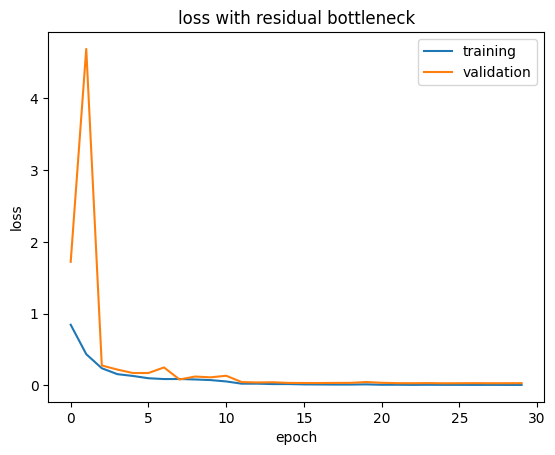

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss with residual bottleneck')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

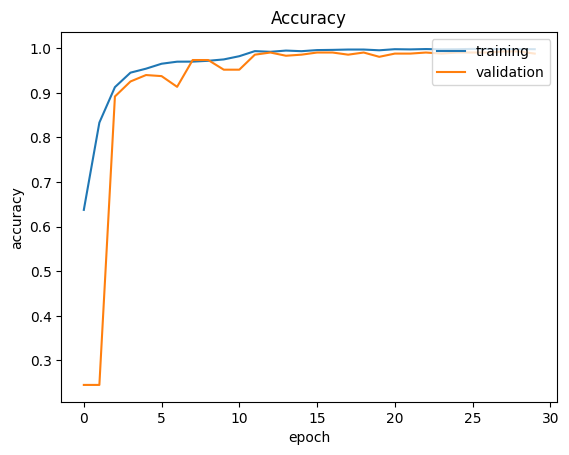

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [17]:
model.evaluate(X_test, y_test)

13/13 [==============================] - 4s 193ms/step - loss: 0.0432 - accuracy: 0.9827


[0.043195635080337524, 0.9827160239219666]

In [23]:
y_pred_baru = np.argmax(model.predict(X_test), axis=1)
y_test_baru = np.argmax(y_test, axis=1)

13/13 [==============================] - 2s 105ms/step


# classification report

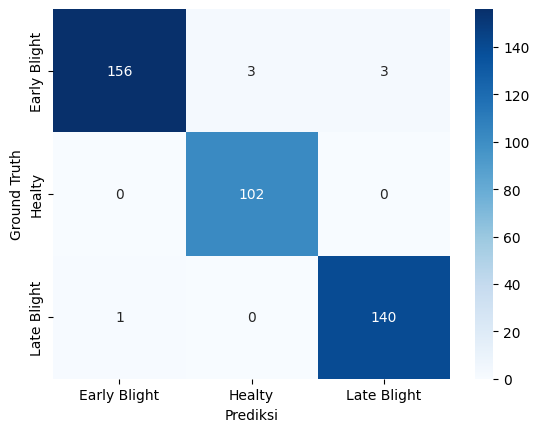

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['Early Blight', 'Healty', 'Late Blight']

# Membuat confusion matrix
cm = confusion_matrix(y_test_baru, y_pred_baru)

# Visualisasi confusion matrix menggunakan heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Mengatur label pada sumbu x dan y
plt.xlabel('Prediksi')
plt.ylabel('Ground Truth')

# Menampilkan plot
plt.show()

In [25]:
from sklearn.metrics import classification_report

target_names = ['Early Blight', 'Healty', 'Late Blight']
report = classification_report(y_test_baru, y_pred_baru, target_names=target_names)

# Menampilkan classification report
print(report)

              precision    recall  f1-score   support

Early Blight       0.99      0.96      0.98       162
      Healty       0.97      1.00      0.99       102
 Late Blight       0.98      0.99      0.99       141

    accuracy                           0.98       405
   macro avg       0.98      0.99      0.98       405
weighted avg       0.98      0.98      0.98       405

